# 1 Importing packages and the functions.py

In [ ]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [ ]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}


# 3 Waveform and Power Analysis

## Extracting LFP data

In [ ]:

keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'} #specifying the map of keyboard annotations to their meanings.
all_bands={'total':[1,100],'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}
importlib.reload(lfp_pre_processing_functions) #Reloading the lfp_pre_processing_functions module to ensure we have the latest version
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat', f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230626_dk6_BW_nocontext_day1.mat'] #This is just for testing purposes

#Initializing a few empty things to store data
events_codes_all = {}
compiled_data_all_epochs = []
compiled_data_list=[]
compiled_shuffled_data_list = []
baseline_lfp_all = []
normalization_comparison_all = []
for file in files: #Looping through data files
    
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)
    date, mouse_id, task=lfp_pre_processing_functions.exp_params(base_name) #Using a custom made function [see functions.py]
    print(date, mouse_id, task)
    if task == 'nocontextday2' or task == 'nocontextos2':
        task = 'nocontext'
    if task =='nocontext':
        continue
    f=h5py.File(file, 'r')  ## Open the data file
    channels = list(f.keys()) ## Extract channels list from the data file
    print(channels)
    if not any("AON" in channel or "vHp" in channel for channel in channels):
        continue
    events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    events_codes=np.array(events['codes'][0]) #saving the keyboard annotations of the events (door open, door close etc.)
    events_times=np.array(events['times'][0]) #saving when the events happened
    events_codes_all[base_name] = events_codes #saving the codes in a dictionary to be analyzed later for events other than the ones in our keyboard_dict map
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)

    # task Start time
    first_event=events_times[0]
    #finding global start and end time of all channels, since they start and end recordings at different times
    global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
    
    ## Reference electrode finding and padding
    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()
    padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)


    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = 2000
            print(channel_id)
            print(raw_data.shape, raw_time.shape, sampling_rate)
            
            padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
            subtracted_data = padded_data - padd_ref_data
            raw_data=subtracted_data
            notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)
            
            data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            first_event_index=np.where(raw_time>first_event)[0][0]

            baseline_row=[mouse_id,task,channel_id,np.array(data_before)]
            baseline_lfp_all.append(baseline_row)
            normalized_data=notch_filtered_data

            #Saving non-normalized data and normalized data for plotting
            normalization_row=[mouse_id,task,channel_id,[notch_filtered_data[first_event_index:first_event_index+30*sampling_rate]],np.mean(data_before),np.std(data_before),[normalized_data[first_event_index:first_event_index+30*sampling_rate]]]
            normalization_comparison_all.append(normalization_row)


            for i,epochi in enumerate(epochs):
                
                compiled_data = pd.DataFrame() # Initializing a dataframe to store the data of a single epoch
                compiled_shuffled_data = pd.DataFrame() # Initializing a dataframe to store the shuffled data of a single epoch
                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                
                
                data_complete_trial=lfp_pre_processing_functions.extract_complete_trial_data(notch_filtered_data,time,door_timestamp,dig_timestamp,sampling_rate,0.7)
                data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,0.7)
                data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,0.7)
                data_door_around=np.append(data_trial_before, data_trial_after)
                data_dig_around=np.append(data_dig_before, data_dig_after)
                epoch_data = [data_complete_trial, data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_door_around, data_dig_around]
                epoch_data = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]
                shuffled_epoch_data = [np.random.permutation(x) for x in epoch_data]  # Shuffle the epoch data
                compiled_data = dict(rat=mouse_id, date=date, task=task, channel=channel_id, trial=i, timestamps=[door_timestamp, dig_timestamp],
                                     side=keyboard_dict.get(str(int(trial_type)), ''), correct=keyboard_dict.get(str(int(dig_type)), ''), time=time,
                                     **dict(zip(['complete_trial', 'pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig'], epoch_data)))
                compiled_shuffled_data = dict(rat=mouse_id, date=date, task=task, channel=channel_id, trial=i, timestamps=[door_timestamp, dig_timestamp],
                                     side=keyboard_dict.get(str(int(trial_type)), ''), correct=keyboard_dict.get(str(int(dig_type)), ''), time=time,
                                     **dict(zip(['complete_trial', 'pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig'], shuffled_epoch_data)))
                compiled_data_list.append(compiled_data)
                compiled_shuffled_data_list.append(compiled_shuffled_data)
def combine_and_save_data(data_list, name):
    compiled_data_all_epochs = []
    compiled_data_all_epochs.extend(data_list)
    compiled_data_all_epochs = pd.DataFrame(compiled_data_all_epochs)
    compiled_data_all_epochs= compiled_data_all_epochs[compiled_data_all_epochs['task']!='nocontext']
    compiled_data_all_epochs.to_pickle(savepath+'{}.pkl'.format(name))

combine_and_save_data(compiled_data_list, 'compiled_data_all_epochs_truncated')
combine_and_save_data(compiled_shuffled_data_list, 'compiled_shuffled_data_all_epochs_truncated')

baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'task', 'channel', 'data'])
baseline_lfp_all.to_pickle(savepath+'baseline_lfp_all.pkl')
normalization_comparison_all = pd.DataFrame(normalization_comparison_all, columns=['rat', 'task', 'channel', 'non_normalized_data', 'baseline_mean', 'baseline_std', 'normalized_data'])   


## 3.1 Waveform Analysis

### Single Rat 1-100Hz around door and digging

In [ ]:
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
waveform_data_all = compiled_data_all_epochs.copy()


In [ ]:
waveform_data_all['channel'] = waveform_data_all['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
event_dictionary = {'around_door':'Before and After door open', 'around_dig': 'Before and After Digging'}
all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}
rat_list=['dk5']
for rat in rat_list:
    writer=pd.ExcelWriter(os.path.join(savepath, f'{rat}_waveform_data.xlsx'), engine='xlsxwriter')
    
    waveform_data = waveform_data_all[waveform_data_all['rat'] == rat]
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    fig.suptitle(f'{rat} LFP (1-100Hz)', fontsize=20)
    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    for subfig in subfigs:
        subfig.patch.set_edgecolor('black')
        subfig.patch.set_linewidth(2)

    areas=['AON','vHp']
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(1, 2)
        subfig.suptitle(f'{area}', fontsize=16)
        waveform_data_area = waveform_data[waveform_data['channel'] == area]
        waveform_data_area = waveform_data_area.reset_index(drop=True)

        for innerind, col in enumerate(['around_door', 'around_dig']):
            data = np.array(waveform_data_area[col].tolist())  # Ensure data is a numpy array
            ax = axs[innerind]  # Correct indexing for axs
            ax.set_title(f'{event_dictionary[col]}', fontsize=16)            
            sheet_dict={}
            for task in (['BWcontext', 'BWnocontext']):
                task_data = data[waveform_data_area['task'] == task]
                
                if len(task_data) > 0:
                    task_data = np.array([functions.freq_band(row, all_bands_dict['total'][0], all_bands_dict['total'][1], 2000) for row in task_data])
                    data_mean = np.mean(task_data, axis=0)
                    data_sem = scipy.stats.sem(task_data, axis=0)
                    time_axis = np.linspace(-0.7, 0.7, len(data_mean))
                    ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
                    sheet_dict[f'{task}_mean'] = data_mean
                    sheet_dict[f'{task}_sem'] = data_sem
            sheet_dict['time'] = time_axis
            sheet_df=pd.DataFrame(sheet_dict)
            sheet_df.to_excel(writer, sheet_name=f'{area}_{col}', index=False)
            ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
            ax.set_xlabel('Time (s)', fontsize=14)
            ax.set_ylabel('Amplitude (uV)', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=14)
            #ax.tick_params(axis='both', which='minor', labelsize=10)
    #writer.close()
    #fig.savefig(os.path.join(savepath,f' LFP_total_waveform_{rat}'), dpi=300)
    plt.show()

### All rats alls bands around door and digging

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
compiled_data_all_epochs = pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window = [-2, 2]  # Set the window for the waveform

#band = 'total'  # Insert the band of interest
tasks = ['BWcontext', 'BWnocontext']
areas=['AON','vHp']
compiled_data_all_epochs['around_door'] = compiled_data_all_epochs['pre_door'].apply(lambda x: x.tolist()) + compiled_data_all_epochs['post_door'].apply(lambda x: x.tolist())
compiled_data_all_epochs['around_dig'] = compiled_data_all_epochs['pre_dig'].apply(lambda x: x.tolist()) + compiled_data_all_epochs['post_dig'].apply(lambda x: x.tolist())
print(np.array(compiled_data_all_epochs['around_door'][0]).shape, np.array(compiled_data_all_epochs['around_dig'][0]).shape)
all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}

for rati in rat_list:
    rat_dict = {}
    rat_data = compiled_data_all_epochs[compiled_data_all_epochs['rat'] == rati]
    rat_data['channel']=rat_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    rat_data = rat_data.reset_index(drop=True)
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    subfigs[1].set_facecolor('0.85')
    fig.suptitle(f'{rati}')
    
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(4, 2)
        
        rat_data_area = rat_data[rat_data['channel'] == area]
        rat_data_area = rat_data_area.reset_index(drop=True)   
    
        for i, band in enumerate(all_bands_dict.keys()):
            rat_data_band=rat_data_area.__deepcopy__()
            for col in (['around_door', 'around_dig']):
                rat_data_band[col] = rat_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

            rat_data_band_grouped = rat_data_band.groupby(['task', 'channel'])
            for (task, channel), group in rat_data_band_grouped:
                group=group.reset_index(drop=True)
                print(group.shape)
                #group['around_dig']=np.concatenate([group['pre_dig'], group['post_dig']], axis=1)
                for j, col in enumerate(['around_door', 'around_dig']):
                    data = np.array(group[col])
                    data_mean = np.mean(data, axis=0)
                    data_sem = scipy.stats.sem(data, axis=0)
                    time_axis = np.linspace(-0.7, 0.7, len(data_mean))
                    ax = axs[i, j]
                    ax.set_title(f'{band} {channel} {col}')
                    ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
                    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
    #fig.savefig(os.path.join(savepath,f' LFP_waveform{rati}'), dpi=300)
    plt.show()
    #plt.close(fig)

### Averaged across rats single band 

In [ ]:
waveform_data = compiled_data_all_epochs.copy()
waveform_data['channel'] = waveform_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
event_dictionary = {'around_door':'Before and After door open', 'around_dig': 'Before and After Digging'}
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
fig.suptitle(f'raw LFP averaged across rats', fontsize=20)

subfigs = fig.subfigures(2, 1)
subfigs=subfigs.flatten()
for subfig in subfigs:
    subfig.patch.set_edgecolor('black')
    subfig.patch.set_linewidth(0.5)
areas=['AON','vHp']
for outerind, area in enumerate(areas):
    subfig=subfigs[outerind]
    axs = subfig.subplots(1, 2)
    subfig.suptitle(f'{area}', fontsize= 16) 
    waveform_data_area = waveform_data[waveform_data['channel'] == area]
    waveform_data_area = waveform_data_area.reset_index(drop=True)

    for innerind, col in enumerate(['around_door', 'around_dig']):
        data = np.array(waveform_data_area[col].tolist())  # Ensure data is a numpy array
        ax = axs[innerind]  # Correct indexing for axs
        ax.set_title(f'{event_dictionary[col]}', fontsize=14)
        for task in (['BWcontext', 'BWnocontext']):
            task_data = data[waveform_data_area['task'] == task]
            if len(task_data) > 0:
            
                data_mean = np.mean(task_data, axis=0)
                data_sem = scipy.stats.sem(task_data, axis=0)
                time_axis = np.linspace(-2, 2, len(data_mean))
                
                ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Amplitude (uV)', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=10)
#fig.savefig(os.path.join(savepath,f' LFP_raw_waveform_averaged'), dpi=300)
plt.show()

### Averaged across rats all bands (To be Deleted later)

In [ ]:
waveform_data = compiled_data_all_epochs.copy()
waveform_data['channel'] = waveform_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
waveform_data = waveform_data.reset_index(drop=True)
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
subfigs = fig.subfigures(2, 1)
subfigs=subfigs.flatten()
subfigs[1].set_facecolor('0.85')
fig.suptitle(f'Waveform')

for i, band in enumerate(all_bands_dict.keys()):
    print(band)

waveform_data_grouped = waveform_data.groupby(['task', 'channel'])
for outerind, area in enumerate(areas):
    subfig=subfigs[outerind]
    axs = subfig.subplots(4, 2)
    waveform_data_area = waveform_data[waveform_data['channel'] == area]
    waveform_data_area = waveform_data_area.reset_index(drop=True)
    
    for i, band in enumerate(all_bands_dict.keys()):
        for col in (['around_door', 'around_dig']):
            waveform_data_area[col+'_'+band] = waveform_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

        data = waveform_data_area[[f'around_door_{band}', f'around_dig_{band}']]
        data_mean = data.groupby(waveform_data_area['task']).mean() 
        data_sem = data.groupby(waveform_data_area['task']).sem()
        time_axis = np.linspace(-2, 2, len(data_mean.columns))
        for j, task in enumerate(tasks):
            ax = axs[i, j]
            ax.set_title(f'{band} {task}')
            ax.plot(time_axis, data_mean.loc[task], color=plotting_styles.colors[task])
            ax.fill_between(time_axis, data_mean.loc[task] - data_sem.loc[task], data_mean.loc[task] + data_sem.loc[task], alpha=0.2, color=plotting_styles.colors[task])
            ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
plt.show() 

# 4 Power Spectra Analysis


## 4.1 Baseline Power

### Baseline PSD

In [ ]:
import plotting_styles

importlib.reload(plotting_styles)
importlib.reload(power_functions)
linestyle = plotting_styles.linestyles
colors = plotting_styles.colors
baseline_lfp_all = pd.read_pickle(savepath+'baseline_lfp_all.pkl')
df= baseline_lfp_all.__deepcopy__()
df['channel']=df['channel'].apply(lambda x:'AON' if 'AON' in x else 'vHp')
channel_experiment_group=df.groupby(['task','channel'])
fig, ax = plt.subplots(figsize=(20, 10))
mean_dict={}
for channel, data in channel_experiment_group:
    print(channel)
    data_array=np.vstack(data['data'].to_numpy())
    print(data_array.shape)
    data_array_welch = np.array([power_functions.apply_welch_transform(row) for row in data_array])
    print(data_array_welch.shape)
    freqs = np.linspace(0,1000,num=int(data_array_welch.shape[1]))  # Assuming the frequency range is 0-1000 Hz
    print(freqs.shape)

    data_array_welch_mean = np.mean(data_array_welch, axis=0)
    data_array_welch_std = np.std(data_array_welch, axis=0)
    print(data_array_welch_mean.shape, data_array_welch_std.shape)
    mean_dict[channel[0] + '_' + channel[1] + '_mean'] = data_array_welch_mean
    mean_dict[channel[0] + '_' + channel[1] + '_std'] = data_array_welch_std
    
    ax.plot(freqs,data_array_welch_mean, linestyle=linestyle[channel[1]], color=colors[channel[0]], label=f'{channel[0]} {channel[1]}')
    ax.fill_between(freqs,data_array_welch_mean-data_array_welch_std,data_array_welch_mean+data_array_welch_std, alpha=0.1, color=colors[channel[0]])
    #ax.set_yscale('log')
    ax.set_xlim(0,100)
    ax.legend()
    ax.set_title('Baseline LFP Power Spectrum')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (uV^2/Hz)')
#    ax.set_yscale('log')
mean_dict['frequency']=data_array_welch[0]
mean_df=pd.DataFrame(mean_dict)
mean_df.to_csv(savepath+'baseline_power_truncated.csv')
plt.savefig(savepath+'baseline_power_truncated.png')
plt.show()
plt.close(fig)

plt.figure(figsize=(10, 5))
plt.plot(tukey_window)
plt.title('Tukey Window')


### BaselinePower Boxplot

In [ ]:
importlib.reload(plotting_styles)
importlib.reload(power_functions)
linestyles = plotting_styles.linestyles
colors = plotting_styles.colors
brain_areas = ['AON','vHp']
df= baseline_lfp_all.__deepcopy__()
number_per_segment = 2000
tukey_window = scipy.signal.get_window(('tukey', 0.2), number_per_segment)    

df['data']=df['data'].apply(lambda x:power_functions.apply_welch_transform(x))

for band_name, band_values in all_bands_dict.items():
    df[band_name+'_power']=df['data'].apply(lambda x:power_functions.get_band_power(x, band_values[0], band_values[1]))

writer=pd.ExcelWriter(savepath+'baseline_power_per_band_truncated.xlsx')
fig, axs = plt.subplots(1,2, figsize=(20, 10), sharey=True)
axs=axs.flatten()
for i, area in enumerate(brain_areas):
    data = df[df['channel'].str.contains(area)]
    data_melted = data.melt(id_vars=['rat','task','channel'], value_vars=['total_power','beta_power','gamma_power','theta_power'], var_name='band', value_name='power')
    sns.boxplot(data=data_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, showfliers=False, ax=axs[i])
    sns.stripplot(data=data_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, dodge=True, alpha=0.5, jitter=0.2, ax=axs[i], linewidth=1, legend=False )
#    axs[i].set_yscale('log')
    axs[i].set_title(f'Baseline {area} Power per Band')
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Power uV^2')
    axs[i].legend()
    axs[i].set_xticks(([0,1,2,3]),list(all_bands_dict.keys()))
    data_melted.to_excel(writer, sheet_name=area)
writer.close()
plt.savefig(savepath+'baseline_power_per_band_truncated.png')
plt.show()

Now we will plot the power spectra for each rat and the mean power spectra

We will plot the power spectra for the complete trial # [NOT USED]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs=axs.flatten()
fig.suptitle('Power Spectral Density')
linestyles = {'AON': '-', 'vHp': '--'}

for i,rati in enumerate(rat_list):
    rat_data=power_df[power_df['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    rat_data_grouped=rat_data.groupby(['task','channel'])
    for (task, channel),group in rat_data_grouped:
        print(task, channel)
        group=group.reset_index(drop=True)
        col='complete_trial'
        data = np.array(group[col])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        freq = np.linspace(0, 1000, len(data_mean))        
        ax = axs[i]
        ax.set_title(f'{rati}')
        ax.plot(freq, data_mean, color=colors[task], linestyle=linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=colors[task])
        ax.set_xlim(0, 100)

4.2 Average Power Spectra across all rats

4.3 Event Power Spectra individual Rats

## 4.2 Events PSD

In [ ]:
importlib.reload(power_functions)
compiled_data_all_epochs = pd.read_pickle(savepath+'compiled_data_all_epochs_truncated.pkl')
power_df=compiled_data_all_epochs.__deepcopy__()
# number_per_segment = 700
# tukey_window = scipy.signal.get_window(('tukey', 0.1), number_per_segment)
columns= ['complete_trial','pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door', 'around_dig']

power_df.loc[:,columns]=power_df.loc[:,columns].applymap(lambda x:power_functions.apply_welch_transform(x))
events_list=['pre_door','post_door','pre_dig','post_dig']
fig, axs=plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
writer=pd.ExcelWriter(savepath+'events_power_spectral_density_truncated.xlsx')
for i, event in enumerate(events_list):

    data = power_df[['rat','task','channel',event]]
    data['channel']=data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups=data.groupby(['task','channel'])
    mean_data_dict={}
    for (task, channel), group in data_groups:
        group=group.reset_index(drop=True)
        data = np.array(group[event])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        mean_data_dict[task+'_'+channel+'_mean']=data_mean
        mean_data_dict[task+'_'+channel+'_sem']=data_sem
        freq = np.linspace(0, 1000, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{event}')
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        #ax.set_yscale('log')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
    mean_df=pd.DataFrame(mean_data_dict)
    mean_df.to_excel(writer, sheet_name=event)
writer.close()
fig.savefig(savepath+'events_power_spectral_density_truncated.png', format='png', dpi=300)
plt.show()


## Plotting the Power for 1s around digging only [NOT USED]

In [ ]:
events_list=['around_dig','around_door']
fig, axs=plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
writer=pd.ExcelWriter(savepath+'events_power_spectral_density.xlsx')
for i, event in enumerate(events_list):

    data = power_df[['rat','task','channel',event]]
    data['channel']=data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups=data.groupby(['task','channel'])
    mean_data_dict={}
    for (task, channel), group in data_groups:
        group=group.reset_index(drop=True)
        data = np.array(group[event])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        mean_data_dict[task+'_'+channel+'_mean']=data_mean
        mean_data_dict[task+'_'+channel+'_sem']=data_sem
        freq = np.linspace(0, 1000, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{event}')
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power uV^2/Hz')
    mean_df=pd.DataFrame(mean_data_dict)
    #mean_df.to_excel(writer, sheet_name=event)
#writer.close()
#plt.savefig(savepath+'events_power_spectral_density.png')
plt.show()




4.5 Power Boxplots

In [ ]:
import seaborn as sns
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs_truncated.pkl')
boxplot_df=compiled_data_all_epochs.__deepcopy__()

boxplot_df.loc[:,['pre_door','post_door','pre_dig','post_dig']]=boxplot_df.loc[:,['pre_door','post_door','pre_dig','post_dig']].applymap(lambda x: power_functions.apply_welch_transform(x))
new_boxplot_df=boxplot_df[['rat', 'task', 'date', 'channel','trial']].copy()
bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in ['pre_door','post_door','pre_dig','post_dig']:
    for band, (band_start, band_end) in bands_dict.items():
        new_boxplot_df[band + '_' + col] = boxplot_df[col].apply(lambda x: power_functions.get_band_power(x, band_start, band_end))

new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task']+ '_' + new_boxplot_df['date']

In [ ]:

all_boxplot_df=new_boxplot_df.__deepcopy__()

all_boxplot_df['channel'] = all_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
aon_channels=all_boxplot_df[all_boxplot_df['channel']=='AON']
vhp_channels=all_boxplot_df[all_boxplot_df['channel']=='vHp']

area_list= ['AON', 'vHp']
for area in area_list:
    area_channels = all_boxplot_df[all_boxplot_df['channel'] == area]
    writer=pd.ExcelWriter(savepath+'events_power_per_band_{}_truncated.xlsx'.format(area), engine='xlsxwriter')
    fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
    axs=axs.flatten()
    events_list=['pre_door','post_door','pre_dig','post_dig']
    for i, event in enumerate(events_list):
        area_df=area_channels.__deepcopy__()
        event_cols = [col for col in area_df.columns if event in col]
        print(event_cols)
        event_df = area_df[['rat', 'task', 'channel','trial', *event_cols]]
        event_df_melted = pd.melt(event_df, id_vars=['rat', 'task', 'channel','trial'], var_name='band', value_name='power')
        event_df_melted['band'] = event_df_melted['band'].apply(lambda x: x.split('_')[0])
        ax=axs[i]
        #sns.boxplot(data=event_df_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, showfliers=False, ax=axs[i])
        #sns.stripplot(data=event_df_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, dodge=True, alpha=0.5, jitter=0.2, ax=axs[i], linewidth=1, legend=False )
        sns.violinplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df_melted, ax=ax)
        #sns.stripplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)

        ax.set_title(event)
        #axs[i].set_yscale('log')
        #axs[i].set_ylim(1e-3, 1e3)
        axs[i].set_ylabel('Power (uV^2)')
        event_df_melted.to_excel(writer, sheet_name=event)
    writer.close()
    plt.savefig(savepath+'events_power_per_band_{}_truncated.png'.format(area))
    plt.show()


## Mean across all trials

In [ ]:
importlib.reload(power_functions)
compiled_data_all_epochs=pd.read_pickle(savepath+'compiled_data_all_epochs_truncated.pkl')
boxplot_df=compiled_data_all_epochs.__deepcopy__()
event_list=['pre_door','post_door','pre_dig','post_dig']
boxplot_df.loc[:,event_list]=boxplot_df.loc[:,event_list].applymap(lambda x: power_functions.apply_welch_transform(x))
new_boxplot_df=power_functions.get_all_band_power_from_welchdf(boxplot_df, event_list)
new_boxplot_df['channel'] = new_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
new_boxplot_df['unique_id'] = new_boxplot_df['rat'] + '_' + new_boxplot_df['task']+ '_' + new_boxplot_df['date']
print(new_boxplot_df.columns)
# Group by unique_id and channel, then take the mean across rows for columns containing 'pre' or 'post'
pre_post_cols = [col for col in new_boxplot_df.columns if ('pre' in col or 'post' in col)]
mean_data_list = []

for (unique_id, channel), group in new_boxplot_df.groupby(['unique_id', 'channel']):
    mean_row = group[pre_post_cols].mean(axis=0)
    # Add identifying columns back
    mean_row['channel'] = channel
    # Optionally, add rat, task, date if you want (take first value in group)
    mean_row['rat'] = group['rat'].iloc[0]
    mean_row['task'] = group['task'].iloc[0]
    mean_data_list.append(mean_row)

mean_df = pd.DataFrame(mean_data_list)
print(mean_df.head())

mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel'], var_name='band', value_name='power')
mean_df_melted['band name']=mean_df_melted['band'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))


('LFP1_vHp',)
['beta_pre_door', 'gamma_pre_door', 'theta_pre_door', 'total_pre_door', 'beta_post_door', 'gamma_post_door', 'theta_post_door', 'total_post_door', 'beta_pre_dig', 'gamma_pre_dig', 'theta_pre_dig', 'total_pre_dig', 'beta_post_dig', 'gamma_post_dig', 'theta_post_dig', 'total_post_dig']
('LFP2_vHp',)
['beta_pre_door', 'gamma_pre_door', 'theta_pre_door', 'total_pre_door', 'beta_post_door', 'gamma_post_door', 'theta_post_door', 'total_post_door', 'beta_pre_dig', 'gamma_pre_dig', 'theta_pre_dig', 'total_pre_dig', 'beta_post_dig', 'gamma_post_dig', 'theta_post_dig', 'total_post_dig']
('LFP3_AON',)
['beta_pre_door', 'gamma_pre_door', 'theta_pre_door', 'total_pre_door', 'beta_post_door', 'gamma_post_door', 'theta_post_door', 'total_post_door', 'beta_pre_dig', 'gamma_pre_dig', 'theta_pre_dig', 'total_pre_dig', 'beta_post_dig', 'gamma_post_dig', 'theta_post_dig', 'total_post_dig']
('LFP4_AON',)
['beta_pre_door', 'gamma_pre_door', 'theta_pre_door', 'total_pre_door', 'beta_post_door',

C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band

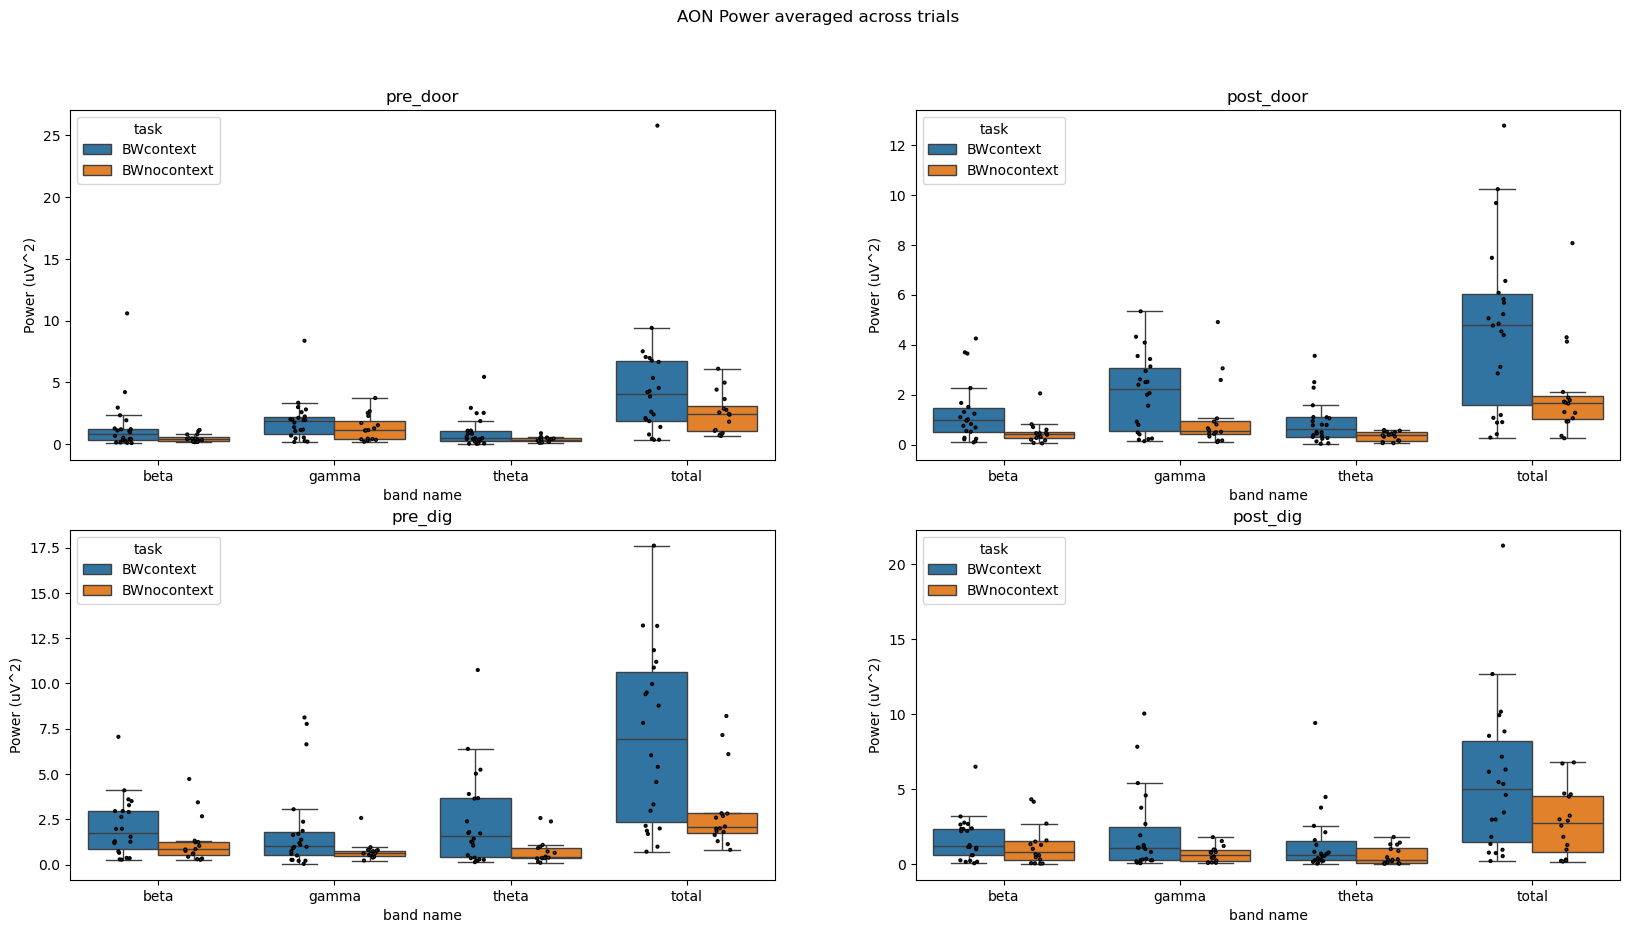

C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_9204\2566919981.py:60: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(x='band

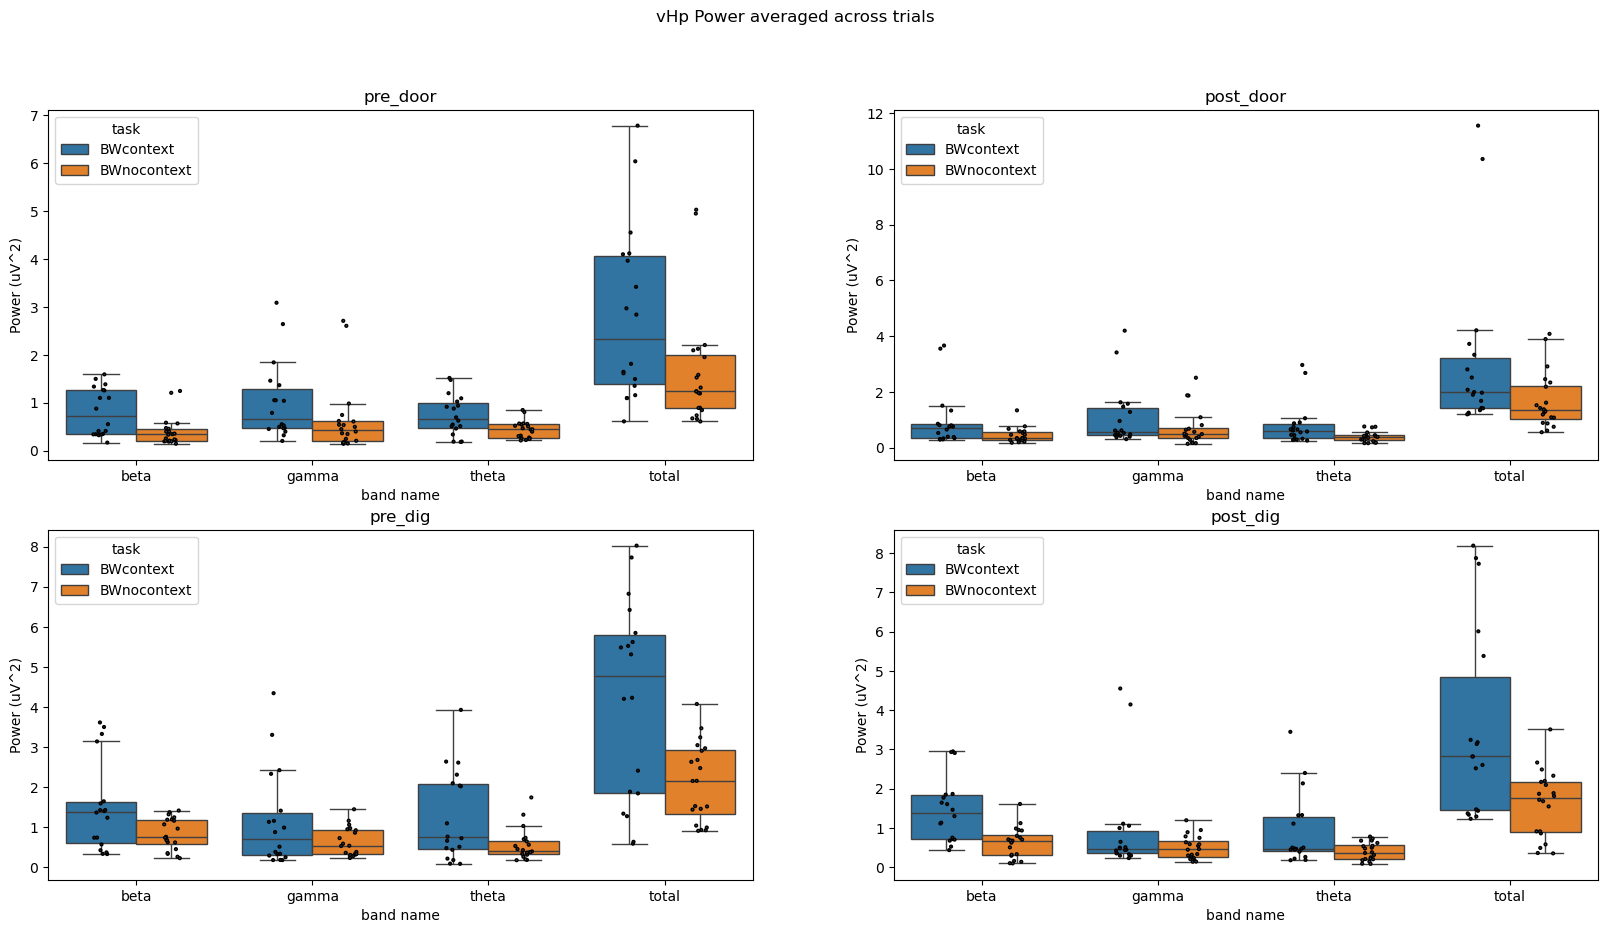

In [87]:
mean_boxplot_df=new_boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]

for unique_id in unique_id_list:
    unique_id_df=mean_boxplot_df[mean_boxplot_df['unique_id']==unique_id]
    unique_id_df_grouped=unique_id_df.groupby(['channel'])
    for channel, group in unique_id_df_grouped:
        print(channel)
        group=group.reset_index(drop=True)
        columns = [col for col in group.columns if 'pre' in col or 'post' in col]
        print(columns)
        rat_id=group['rat'].iloc[0]
        task_id=group['task'].iloc[0]
        date_id=group['date'].iloc[0]
        channel_id=group['channel'].iloc[0]
        mean_data_dict={}
        for col in columns:
            data=np.array(group[col])
            data_mean=np.mean(data,axis=0)
            data_sem=scipy.stats.sem(data,axis=0)
            mean_data_dict[col+'_mean']=data_mean
            mean_data_dict[col+'_sem']=data_sem
        mean_data_dict['rat']=rat_id
        mean_data_dict['task']=task_id
        mean_data_dict['date']=date_id
        mean_data_dict['channel']=channel_id
        mean_data_list.append(mean_data_dict)
mean_df=pd.DataFrame(mean_data_list)
mean_df.drop(columns=['date'], inplace=True)


mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel'], var_name='band', value_name='power')
mean_df_melted['band name']=mean_df_melted['band'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted['type']=mean_df_melted['band'].apply(lambda x: x.split('_')[-1])
cols = list(mean_df_melted.columns)
cols.append(cols.pop(cols.index('power')))
mean_df_melted = mean_df_melted[cols]
mean_df_melted.drop(columns=['band'], inplace=True)
mean_df_melted_grouped=mean_df_melted.groupby(['event'])
writer=pd.ExcelWriter(savepath+'mean_across_trials_power_truncated.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group=group.reset_index(drop=True)
    group.to_excel(writer, sheet_name=event[0])
writer.close()
arealist=['AON','vHp']
for area in arealist:
    fig,axs=plt.subplots(2,2,figsize=(20,10))
    fig.suptitle(area + ' Power averaged across trials ')
    axs=axs.flatten()
    events=['pre_door','post_door','pre_dig','post_dig']
    for i,event in enumerate(events):
        ax=axs[i]
        ## Plotting AON mean power
        plotting_df=mean_df_melted[(mean_df_melted['channel'].str.contains(area)) & (mean_df_melted['type']=='mean') & (mean_df_melted['event']==event)] 
        sns.boxplot(x='band name',y='power',hue='task',data=plotting_df,ax=ax, showfliers=False)
        sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
        #ax.set_yscale('log')
        ax.set_ylabel('Power (uV^2)')
        ax.set_title(event)
    fig.savefig(savepath+f'mean_power_across_trials_{area}_truncated.png', format='png', dpi=300)
    plt.show()

#mean_df=pd.DataFrame(mean_data_dict)

Taking a mean across channels


In [ ]:
mean_boxplot_df=boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]
sem_data_list=[]
mean_boxplot_df['channel']=mean_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
mean_boxplot_df_grouped=mean_boxplot_df.groupby(['task', 'channel', 'trial'])
for (task, channel, trial), group in mean_boxplot_df_grouped:
    print(task, channel, trial)
    group=group.reset_index(drop=True)
    columns=group.columns[-21:-1]
    data_array=np.array(group[columns])
    data_mean=np.mean(data_array, axis=0)
    data_sem=scipy.stats.sem(data_array, axis=0)
    print(data_mean)
    print(data_sem)
    mean_data_dict = {col: data_mean[idx] for idx, col in enumerate(columns)}
    sem_data_dict = {col: data_sem[idx] for idx, col in enumerate(columns)}
    mean_data_dict['task'] = task
    mean_data_dict['channel'] = channel
    mean_data_dict['trial'] = trial
    sem_data_dict['task'] = task
    sem_data_dict['channel'] = channel
    sem_data_dict['trial'] = trial
    mean_data_list.append(mean_data_dict)
    sem_data_list.append(sem_data_dict)

mean_df = pd.DataFrame(mean_data_list)
fig, ax = plt.subplots(figsize=(10, 6))
for task in ['BWcontext', 'BWnocontext']:
    task_data = mean_df[(mean_df['task'] == task) & (mean_df['channel'] == 'AON')]
    ax.plot(task_data['trial'], task_data['total_complete_trial'], label=task, marker='o')
ax.set_xlabel('Trial Number')
ax.set_ylabel('AON Power in total complete trial')
ax.set_title('AON Power in total complete trial across Trials')
ax.set_xticks(np.arange(0, 20, 1))
ax.legend()
plt.show()


Mean in groups of 5 trials

In [ ]:
boxplot_df_grouped=boxplot_df.groupby(['unique_id'])
mean_data_list=[]
for unique_id, group in boxplot_df_grouped:
    print(unique_id)
    num_of_trials=len(group['trial'].unique())
    print(num_of_trials)
    group=group.reset_index(drop=True)
    print()
    for channel in group['channel'].unique():
        i=0
        group_channel=group[group['channel']==channel]
        group_channel=group_channel.reset_index(drop=True)
        
        while i < 16:
            print(i)
            group_trial = group_channel[(group_channel['trial'] >= i) & (group_channel['trial'] < i + 4)]
            group_trial_data_array = np.array(group_trial.loc[:, 'beta_pre_door':'total_around_dig'])
            data_mean= group_trial_data_array.mean(axis=0)
            row = {**group_channel.iloc[0][['rat', 'task', 'channel', 'unique_id']].to_dict(),
                   **{'trial': f'{i}-{i + 4}'},
                   **dict(zip(group_trial.loc[:, 'beta_pre_door':'total_around_dig'].columns, data_mean))}
            mean_data_list.append(row)

            i=i+4
mean_df = pd.DataFrame(mean_data_list)
mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel','trial', 'unique_id'], var_name='band_event', value_name='power')
mean_df_melted['band name']=mean_df_melted['band_event'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band_event'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted_grouped=mean_df_melted.groupby(['event'])
writer=pd.ExcelWriter(savepath+'power_boxplot_average_per_4_trials.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group=group.reset_index(drop=True)
    group.drop(columns=['band_event','event'], inplace=True)
    group.to_excel(writer, sheet_name=event[0])
writer.close()

Plotting Power Spectrograms

In [ ]:
from scipy.signal import spectrogram

power_spec_df = compiled_data_all_epochs.__deepcopy__()
print(power_spec_df.iloc[0,-2].shape)


In [ ]:
power_spec_df.iloc[:, -2:] = power_spec_df.iloc[:, -2:].applymap(lambda x: spectrogram(x, fs=2000, nperseg=512))

In [ ]:
print(power_spec_df.iloc[0,-2][1])
for col in ['around_door','around_dig']:

    power_spec_df[col+'_f'] = power_spec_df[col].apply(lambda x: x[0])
    power_spec_df[col+'_t'] = power_spec_df[col].apply(lambda x: x[1])
    power_spec_df[col+'_sxx'] = power_spec_df[col].apply(lambda x: x[2])
    

In [ ]:
power_spec_df['channel'] = power_spec_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
power_spec_df_grouped = power_spec_df.groupby(['task', 'channel'])
for (task, channel), group in power_spec_df_grouped:
    group = group.reset_index(drop=True)
    for col in ['around_door', 'around_dig']:
        data = np.array(group[col + '_sxx'])
        data_mean = np.mean(data, axis=0)
        print(data_mean.shape)
        freq = group[col + '_f'].iloc[0]
        time = group[col + '_t'].iloc[0]
        time_adjusted=np.linspace(-2,2,len(time))
        fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
        im = ax.pcolormesh(time_adjusted, freq, data_mean, shading='gouraud', vmin=0, vmax=0.5)
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{task} {channel} {col}')
        ax.set_ylim(0, 100)
        # ax.set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
        # ax.set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
        ax.vlines(0, 0, 100, color='red', linestyle='--')
        ax.set_xlabel('Time (s)', fontsize=20)

        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel('Frequency (Hz)', fontsize=20)
        i = i + 1
        fig.savefig(savepath + f'power_mean_spectrogram_{task}_{channel}_{col}.png', dpi=300)
        plt.show()


# 6. Coherence Measures

## Testing Coherence functions

In [ ]:
### Generating static data
import numpy as np
import matplotlib.pyplot as plt
import mne
importlib.reload(coherence_functions)
# --- Basic Parameters ---
sfreq = 1000  # Sampling frequency in Hz
n_epochs = 20  # Number of trials
n_times = 2000  # Number of time points per trial (2 seconds of data)
times = np.arange(n_times) / sfreq  # Time vector for one epoch
n_signals = 3  # We'll create 3 channels

# We will test connectivity in the beta band
freq_of_interest = 20.0  # 20 Hz
# --- Generate Data for Static Connectivity ---

# Initialize data array: (n_epochs, n_signals, n_times)
static_data = np.random.randn(n_epochs, n_signals, n_times) * 0.1  # Add background noise

# Create the shared 20 Hz sine wave component
shared_signal = np.sin(2 * np.pi * freq_of_interest * times)

# Add the shared signal to the first two channels for all epochs
static_data[:, 0, :] += shared_signal
static_data[:, 1, :] += shared_signal

print("Shape of static_data:", static_data.shape)
ch_names=['AON', 'vHp', 'PFC']  # Example channel names
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
static_data_mne=mne.EpochsArray(static_data, info)
print(static_data_mne)
# Plot the static_data for each channel in the first epoch
fig, axs = plt.subplots(n_signals, 1, figsize=(12, 6), sharex=True)
for i, ch in enumerate(ch_names):
    axs[i].plot(times, static_data[0, i, :], label=f'Channel: {ch}')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend(loc='upper right')
axs[-1].set_xlabel('Time (s)')
plt.suptitle('Static Data Example (Epoch 0)')
plt.tight_layout()
plt.show()
coherence_band_sce = coherence_functions.convert_epoch_to_coherence(static_data_mne)
print(coherence_band_sce)
coherence_band_time=coherence_functions.convert_epoch_to_coherence_time(static_data_mne)
print(coherence_band_time)

## Truncating LFP data and loading it into MNE arrays

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_connectivity
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        if rat_id=='dk3':
            continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        #print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        #print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_around_door=np.zeros((len(epochs),len(all_channels),2800))
        mne_epoch_around_dig=np.zeros((len(epochs),len(all_channels),2800))
        
        mne_baseline_data_shuffled=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before_shuffled=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_door_after_shuffled=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_dig_before_shuffled=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_dig_after_shuffled=np.zeros((len(epochs),len(all_channels),1400))
        mne_epoch_around_door_shuffled=np.zeros((len(epochs),len(all_channels),2800))
        mne_epoch_around_dig_shuffled=np.zeros((len(epochs),len(all_channels),2800))



        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                #print(raw_data.shape, raw_time.shape, sampling_rate)
                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
                subtracted_data = padded_data - padd_ref_data
                raw_data=subtracted_data
                notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)

                data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                first_event_index=np.where(raw_time>first_event)[0][0]

                mne_baseline_data[0,channel_num,:]=list(data_before)
                mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
                total = notch_filtered_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    #print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    #print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,0.7)
                    data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,0.7)
                    data_around_door=np.concatenate((data_trial_before, data_trial_after))
                    data_around_dig=np.concatenate((data_dig_before, data_dig_after))

                    epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
                    event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
                    mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4])
                    mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5])

                    mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0]))
                    mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1]))
                    mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2]))
                    mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3]))
                    mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4]))
                    mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5]))

        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/3
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
            mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
            
            row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
            mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
            mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
            mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
            mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
            mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
            mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
            mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
            row_list_shuffled=[file_num,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
            shuffled_event_data_df.append(row_list_shuffled)

            con_data_df.append(row_list)
            con_data_df_shuffled.append(row_list_shuffled)


con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df.to_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df_shuffled.to_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')


In [ ]:
print(np.append(event_data_list[2],event_data_list[3]))
print(event_data_list[2])
print(event_data_list[3])
print((np.append(event_data_list[2],event_data_list[3]))[3000:5000])


## 6.1 Baseline Coherence Density

In [ ]:
importlib.reload(coherence_functions)
con_data_df=pd.read_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')
baseline_df=con_data_df.__deepcopy__()
baseline_df=baseline_df[baseline_df['rat_id']!='dk3']
baseline_df['mne_baseline']=baseline_df['mne_baseline'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_density(x))

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
writer=pd.ExcelWriter(savepath+'baseline_coherence_density_shuffled_truncated.xlsx')
baseline_df_grouped=baseline_df.groupby(['task'])
task_dict={'BWcontext':'Context','BWnocontext':'No Context'}
baseline_dict={}
for (task, group) in baseline_df_grouped:
    print(task[0])
    group=group.reset_index(drop=True)
    data = np.array(group['mne_baseline'].tolist())
    data_mean = np.mean(data, axis=0)
    data_sem = scipy.stats.sem(data, axis=0)
    freq = np.linspace(0, 100, len(data_mean))
    ax.plot(freq, data_mean, label=task_dict[task[0]])
    ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2)
    ax.set_xlim(0, 100)
    ax.set_title(f'Baseline AON-vHp Coherence Density')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence (A.U.)')
    ax.legend()
    baseline_dict[f'{task[0]}_mean'] = data_mean
    baseline_dict[f'{task[0]}_sem'] = data_sem
baseline_dict['frequency'] = freq
mean_df = pd.DataFrame(baseline_dict)
mean_df.to_excel(writer, sheet_name='mean_coherence_density')
writer.close()
fig.savefig(savepath+'baseline_coherence_density_shuffled_truncated.png', dpi=300)
plt.show()

## 6.2 Baseline Coherence Boxplots

In [ ]:
importlib.reload(coherence_functions)
con_data_df=pd.read_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')
baseline_df=con_data_df.__deepcopy__()
baseline_df=baseline_df[baseline_df['rat_id']!='dk3']
baseline_df['mne_baseline']=baseline_df['mne_baseline'].apply(lambda x: coherence_functions.convert_epoch_to_coherence(x))

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(20, 10), sharex=True, sharey=True)
writer=pd.ExcelWriter(savepath+'baseline_coherence_per_band_shuffled_truncated.xlsx')
event='mne_baseline'
event_data=baseline_df['mne_baseline']
event_data_df = pd.DataFrame(event_data.tolist())
event_data_df.reset_index(drop=True, inplace=True)
event_data_df['rat_id'] = baseline_df['rat_id'].reset_index(drop=True)
event_data_df['task'] = baseline_df['task'].reset_index(drop=True)
event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
sns.boxplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, showfliers=False, legend=False, ax=axs)
sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)

#axs.set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
axs.set_title('Baseline Coherence')
axs.set_ylabel('Coherence')
axs.set_xlabel('')

event_data_df_melted.to_excel(writer, sheet_name=event)
writer.close()

fig.savefig(savepath+'baseline_coherence_per_band_shuffled_truncated.png')
plt.show()


## 6.3 Coherence around events [door before, door after, dig before, dig after]

### Calculating AON-vHp connectivity Spectrogram from Epochs Array and Saving if as a pkl file

In [ ]:
con_data_df=pd.read_pickle(savepath+'mne_epochs_array_df_truncated.pkl')
event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']
print(event_list)
BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
fs=2000

rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/3
                           
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                coherence= coh[i,j,:,:]
                                coherence=np.arctanh(coherence) #apply Fisher's z-transformation
                                aon_vHp_con.append(coherence)
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
all_con_data_df.to_pickle(savepath+'coherence_spectrogram_around_events.pkl')
fs=2000


In [ ]:
all_con_data_df=pd.read_pickle(savepath+'coherence_spectrogram_around_events.pkl')
event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

times=np.arange(0, 2, 1/fs)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png', dpi=300)
plt.show()

## 6.4 Coherence around events [around door and around dig]

### Calculating AON-vHp connectivity around door and dig and saving it in a pkl file

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
        row=[task_name]
         #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    fs=2000
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/3
                    con= mne_connectivity.spectral_connectivity_time(event_epoch, method='coh', sfreq=int(fs), average=False,
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    print(coh.shape, indices)
                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                coherence= coh[i,j,:]
                                coherence=np.arctanh(coherence)
                                aon_vHp_con.append(coherence)

                    # con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                    #                                      mode='cwt_morlet', cwt_freqs=freqs,
                    #                                      cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    # coh = con.get_data(output='dense')
                    # indices = con.names
                    

                    # for i in range(coh.shape[0]):
                    #     for j in range(coh.shape[1]):
                    #         if 'AON' in indices[j] and 'vHp' in indices[i]:
                    #             coherence= coh[i,j,:,:]
                    #             coherence=np.arctanh(coherence)
                    #             aon_vHp_con.append(coherence)
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
all_con_data_df.to_pickle(savepath+'coherence_spectrogram_around_door_dig_truncated.pkl')
fs=2000
all_con_data_df=pd.read_pickle(savepath+'coherence_spectrogram_around_door_dig_truncated.pkl')
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png',format='png', dpi=600, bbox_inches='tight')
plt.show()

Difference in coherence between BWContext and BWnOContext


In [ ]:
all_con_data_df_net=all_con_data_df.__deepcopy__()
all_con_data_df_net.set_index('task', inplace=True)
all_con_data_df_net.loc['difference'] = all_con_data_df_net.loc['BWcontext'] - all_con_data_df_net.loc['BWnocontext']
all_con_data_df_net.reset_index(inplace=True)

fs=2000
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(1,2, figsize=(20,10), sharey=True)
fig.suptitle('Difference in Coherence between BW Context and BW No Context')
axs=axs.flatten()
vmin = all_con_data_df_net[event_list].applymap(np.min).min().min()
vmax = all_con_data_df_net[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[i].imshow(all_con_data_df_net[event][2], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(event_names[i])
    axs[i].vlines(0, 0, 100, color='k', linestyle='--')

cbar = fig.colorbar(axs[0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png', dpi=300)
plt.show()


## 6.4 Coherence Boxplots 

### Calculating Aon-vHp connectivity per band and storing it in pkl file

In [ ]:
import seaborn as sns
importlib.reload(coherence_functions)
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

rat_list=['dk1', 'dk5', 'dk6']
single_baseline_epoch=con_data_df_clean['mne_epoch_door_before'].iloc[0]
theta_band=[4,8]

theta_coherence=coherence_functions.convert_epoch_to_coherence_time(single_baseline_epoch)
print(theta_coherence)


In [ ]:
importlib.reload(coherence_functions)
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

con_data_df_clean['coherence_door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x))
con_data_df_clean['coherence_door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x))
con_data_df_clean['coherence_dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x))
con_data_df_clean['coherence_dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: coherence_functions.convert_epoch_to_coherence_mt(x))
con_data_df_clean.drop(columns=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'], inplace=True)
con_data_df_clean.to_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value_truncated_mt.pkl')

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value_truncated_mt.pkl')
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
axs = axs.flatten()
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_event_per_band_truncated_mt.xlsx')
for i, event in enumerate(['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']):
    event_data = con_data_df_clean[event]
    event_data_df = pd.DataFrame(event_data.tolist())
    event_data_df.reset_index(drop=True, inplace=True)
    event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
    event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
    event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
    sns.boxplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, showfliers=False, legend=False, ax=axs[i])
    sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    #axs[i].set_xticklabels(['Total', 'Theta', 'Beta', 'Gamma'])
    axs[i].set_title(event)
    axs[i].set_ylabel('Coherence')
    axs[i].set_xlabel('')
    event_data_df_melted.to_excel(writer, sheet_name=event)
writer.close()
# Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

# Create custom legend handles and labels
handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='BWcontext'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='BWnocontext')
]

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.1, 1), title='Task')
fig.savefig(savepath+'coherence_event_per_band_truncated_mt.png', format='png',dpi=300)
plt.tight_layout()
plt.show()


Plotting AON-vHp connectivity separated by Bands ## [NOT USED]

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value.pkl')

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
writer = pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_band_per_event.xlsx')

bands = ['total', 'theta', 'beta', 'gamma']
events = ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']

for i, band in enumerate(bands):
    band_data = []
    for event in events:
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df['event'] = event
        event_data_df['band'] = band
        event_data_df['coherence'] = event_data_df[band]
        band_data.append(event_data_df[['rat_id', 'task', 'event', 'band', 'coherence']])
    
    band_data_df = pd.concat(band_data, ignore_index=True)
    sns.boxplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, showfliers=False, legend=False, ax=axs[i])
    sns.stripplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    axs[i].set_xticklabels(['Door Before', 'Door After', 'Dig Before', 'Dig After'], rotation=0)
    axs[i].set_title(band.capitalize())
    axs[i].set_ylabel('Coherence')
    axs[i].set_xlabel('')
    band_data_df.to_excel(writer, sheet_name=band)

writer.close()

# Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='BWcontext'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='BWnocontext')
]

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.1, 1), title='Task')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_band_per_event.png', dpi=600)
plt.tight_layout()
plt.show()

Same boxplot as above but for a single band ## [NOT USED]

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'coherence_boxplot_per_event_per_band_single_value.pkl')

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

bands = ['beta']
events = ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']

for i, band in enumerate(bands):
    band_data = []
    for event in events:
        event_data = con_data_df_clean[event]
        event_data_df = pd.DataFrame(event_data.tolist())
        event_data_df.reset_index(drop=True, inplace=True)
        event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
        event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
        event_data_df['event'] = event
        event_data_df['band'] = band
        event_data_df['coherence'] = event_data_df[band]
        band_data.append(event_data_df[['rat_id', 'task', 'event', 'band', 'coherence']])
    
    band_data_df = pd.concat(band_data, ignore_index=True)
    sns.boxplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, showfliers=False, legend=False, ax=axs)
    sns.stripplot(x='event', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=band_data_df, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)
    axs.set_xticklabels(['Pre Door', 'Post Door', 'Pre Dig', 'Post Dig'], rotation=0)
    axs.set_title(band.capitalize()+' Band Coherence between AON and vHp', fontsize=20)
    
    axs.set_ylabel('Coherence', fontsize=20)
    axs.set_xlabel('Behavior Events', fontsize=20)
    axs.tick_params(axis='both', which='major', labelsize=20)
    axs.tick_params(axis='both', which='minor', labelsize=20)
    #axs.legend(title='', fontsize=20, loc='upper right' )
# # Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='Context'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='No Context')
]
plt.tight_layout()

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.4, 0.95), title='', fontsize=20, ncol=1)
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_beta_band_per_event.png', dpi=600, bbox_inches='tight')

plt.show()

# GC measures


In [ ]:
con_data_df=pd.read_pickle(savepath+'mne_epochs_array_df.pkl')
#con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after',
                                               #'mne_epoch_dig_before','mne_epoch_dig_after', 'mne_epoch_around_door', 'mne_epoch_around_dig'])
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
con_data_df_clean=con_data_df_clean[con_data_df_clean['task']!='nocontext']


def calculate_net_gc(mne_data):
        aon_signals=[
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "AON" in ch_info["ch_name"]
        ]
        print(aon_signals)
        vhp_signals=[
            idx
            for idx, ch_info in enumerate(mne_data.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        print(vhp_signals)

        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))

        gc_ab = mne_connectivity.spectral_connectivity_epochs(
        mne_data,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
        )
        freqs = gc_ab.freqs

        gc_ba = mne_connectivity.spectral_connectivity_epochs(
            mne_data,
            method=["gc"],
            indices=indices_vhp_aon,
            fmin=2.5,
            fmax=100,
            rank=None,
            gc_n_lags=20,
        )
        freqs = gc_ba.freqs

        net_gc = gc_ab.get_data() - gc_ba.get_data()
        return net_gc[0], freqs

gc_data_df=pd.DataFrame()
gc_data_df['rat_id']=con_data_df_clean['rat_id']
gc_data_df['task']=con_data_df_clean['task']
gc_data_df['door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['around_door']=con_data_df_clean['mne_epoch_around_door'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['around_dig']=con_data_df_clean['mne_epoch_around_dig'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['around_door_truncated']=con_data_df_clean['mne_epoch_around_door_truncated'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['around_dig_truncated']=con_data_df_clean['mne_epoch_around_dig_truncated'].apply(lambda x: calculate_net_gc(x)[0])

gc_data_df['freqs']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x)[1])
gc_data_df['freqs_door']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_net_gc(x)[1])
gc_data_df['freqs_trunc']=con_data_df_clean['mne_epoch_around_door_truncated'].apply(lambda x: calculate_net_gc(x)[1])

gc_data_df=pd.DataFrame(gc_data_df, columns=['rat_id','task','door_before','door_after','dig_before','dig_after','around_door','around_dig','around_door_truncated','around_dig_truncated', 'freqs', 'freqs_door','freqs_trunc'])



In [ ]:
import scipy.stats
gc_data_df_bwcontext=gc_data_df[gc_data_df['task']=='BWcontext']
gc_data_df_bwnocontext=gc_data_df[gc_data_df['task']=='BWnocontext']
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_BWcontext_vs_BWnocontext_AON_vHp.xlsx')

fig,axs=plt.subplots(4,2, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('BW Context vs  BW No Context AON-vHp Granger Causality')
events_dict={'door_before': 'Door Before','door_after': 'Door After','dig_before': 'Dig Before','dig_after': 'Dig After','around_door': 'Around Door','around_dig': 'Around Dig','around_door_truncated': 'Around Door Truncated','around_dig_truncated': 'Around Dig Truncated'}
for i,event in enumerate(events_dict.keys()):
    ax=axs[i]
    bwcontext_mean=np.mean(gc_data_df_bwcontext[event], axis=0)
    bwnocontext_mean=np.mean(gc_data_df_bwnocontext[event], axis=0)
    bwcontext_sem=scipy.stats.sem(gc_data_df_bwcontext[event], axis=0)
    bwnocontext_sem=scipy.stats.sem(gc_data_df_bwnocontext[event], axis=0)
    
    freqs=np.linspace(2.5,100,len(bwcontext_mean))
    
    mean_dict={'frequency':freqs,'bwcontext':bwcontext_mean,'bwnocontext':bwnocontext_mean,'bwcontext_sem':bwcontext_sem,'bwnocontext_sem':bwnocontext_sem}
    mean_df=pd.DataFrame(mean_dict)
    mean_df.to_excel(writer, sheet_name=event)

    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.axvspan(4,12, alpha=0.2, color='red', label='Theta Range')
    ax.axvspan(12,30, alpha=0.2, color='green', label='Beta Range')
    ax.axvspan(30,80, alpha=0.2, color='grey', label='Gamma Range')
    ax.plot(freqs, bwcontext_mean, linewidth=2, label='BWcontext mean')
    ax.fill_between(freqs, bwcontext_mean - bwcontext_sem, bwcontext_mean + bwcontext_sem, alpha=0.2, label='BWcontext SEM')
    ax.plot(freqs, gc_data_df_bwnocontext[event].mean(), linewidth=2, label='BW no context mean')
    ax.fill_between(freqs, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, alpha=0.2, label='BW no context SEM')    
    ax.set_title(f"{events_dict[event]}", fontsize=8)
    #ax.legend()
writer.close()
fig.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_BWcontext_vs_BWnocontext_AON_vHp.png')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
#%matplotlib qt
bands_dict={'total':[2.5,100],'theta': [4,12],'beta':[12,30],'gamma':[30,80], 'beta+theta':[4,30]}

def calculate_gc_per_band(gc_array,freqs_array, bands_dict):
    freqs_array = np.array(freqs_array)  # Convert freqs_array to numpy array
    print(len(gc_array))
    gc_bands_dict={}
    for band in bands_dict.keys():
        band_indices=np.where((freqs_array>=bands_dict[band][0]) & (freqs_array<=bands_dict[band][1]))
        gc_band=gc_array[band_indices]

        gc_bands_dict[band]=(np.sum(gc_band)*0.5)/len(gc_band)

    return gc_bands_dict

test_gc=gc_data_df_bwcontext['door_before'].iloc[0]
test_freqs=gc_data_df_bwcontext['freqs'].iloc[0]
test_gc_band=calculate_gc_per_band(test_gc,test_freqs, bands_dict)

gc_cols = ['door_before', 'door_after', 'dig_before', 'dig_after','around_door','around_dig', 'around_door_truncated', 'around_dig_truncated']
gc_data_df_bands = []

for index, row in gc_data_df.iterrows():
    rat_id = row['rat_id']
    task = row['task']
    for gc_col in gc_cols:
        if gc_col=='around_door_truncated' or gc_col=='around_dig_truncated':
            freqs = row['freqs_trunc']
        elif gc_col=='around_door' or gc_col=='around_dig':
            freqs = row['freqs_door']
        else:
            freqs = row['freqs']
        gc_values = calculate_gc_per_band(row[gc_col], freqs, bands_dict)
        for band, gc_value in gc_values.items():
            gc_data_df_bands.append({
                'rat_id': rat_id,
                'task': task,
                'event': gc_col,
                'band': band,
                'gcvalue': gc_value
            })

gc_data_df_bands = pd.DataFrame(gc_data_df_bands)
gc_data_df_bands=gc_data_df_bands[gc_data_df_bands['task']!='nocontext']
print(gc_data_df_bands)
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_net_AoN_vHp.xlsx')
fig, axs=plt.subplots(4,2, sharex=False, sharey=True, figsize=(15,10))
axs=axs.flatten()
fig.suptitle('Average Net AON -> vHp granger causality per band')
for i, event in enumerate(gc_cols):
    print(i, event)
    ax=axs[i]
    gc_event=gc_data_df_bands[gc_data_df_bands['event']==event]
    gc_event.to_excel(writer, sheet_name=event)
    ax.axhline(0, color='black', lw=1)
    sns.boxplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,showfliers=False, ax=ax)
    sns.stripplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax)
    ax.set_title(f"{event}", fontsize=10)
    ax.set_xlabel('')

fig.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_net_AoN_vHp.png')
plt.show()

writer.close()

## Making GC Spectrograms

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']

print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

rat_list=np.unique(con_data_df_clean['rat_id'])
print(rat_list)
all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/2
                    
                    ###Specifying the Indices for AON and vHp channels
                    aon_signals=[
                    idx
                    for idx, ch_info in enumerate(event_epoch.info["chs"])
                    if "AON" in ch_info["ch_name"]
                    ]
                    print(aon_signals)
                    vhp_signals=[
                        idx
                        for idx, ch_info in enumerate(event_epoch.info["chs"])
                        if "vHp" in ch_info["ch_name"]
                    ]
                    print(vhp_signals)

                    indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
                    indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))      
                    gc_ab = mne_connectivity.spectral_connectivity_epochs(event_epoch, method=["gc"], indices=indices_aon_vhp, fmin=2.5, fmax=100, rank=None,gc_n_lags=20)
                    gc_ba= mne_connectivity.spectral_connectivity_epochs(event_epoch, method=["gc"], indices=indices_vhp_aon, fmin=2.5, fmax=100, rank=None,gc_n_lags=20)
                    net_gc= gc_ab.get_data() - gc_ba.get_data()
                    print(net_gc.shape)

                    coh = net_gc[0]
                    #coh=np.abs(coh)
                    print(coh.shape)
                    indices = coh.names
                    print(indices)

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                aon_vHp_con.append(coh[i,j,:,:])
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
#all_con_data_df.to_pickle(savepath+'coherence_spectrogram_around_door_dig.pkl')
fs=2000
event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram.png',format='png', dpi=600, bbox_inches='tight')
plt.show()


## Calculating complex coherence values

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
for i in range(con_data_df_clean.shape[0]):
    test_data=con_data_df_clean.iloc[i,-1]
    print(test_data)
    fmin=1
    fmax=100
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/2
    con_complex=mne_connectivity.spectral_connectivity_epochs(test_data, method='cohy', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
    import numpy as np
    import matplotlib.pyplot as plt

    def pol2cart(rho, phi):
        """
        Convert polar coordinates to Cartesian coordinates.
        rho: magnitude
        phi: phase (in radians)
        Returns: x, y Cartesian components
        """
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return(x, y)
    coh_complex = con_complex.get_data(output='dense')
    indices = con_complex.names
    coh_phase = np.angle(coh_complex)
    coh = np.abs(coh_complex)
    print(coh.shape)
    print(coh_phase.shape)
    print(coh.shape)
    aon_vHp_con=[]
    aon_vhp_phase=[]
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            if 'AON' in indices[j] and 'vHp' in indices[i]:
                aon_vHp_con.append(coh[i,j,:,:])
                aon_vhp_phase.append(coh_phase[i,j,:,:])

    aon_vHp_con=np.array(aon_vHp_con)
    aon_vhp_phase=np.array(aon_vhp_phase)


    all_con_data_df=np.mean(aon_vHp_con, axis=0)
    aon_vhp_phase=np.mean(aon_vhp_phase, axis=0)

    fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
    vmin = np.min(all_con_data_df)
    vmax = np.max(all_con_data_df)
    times = np.arange(-2, 2, 1/fs)

    plt.imshow(all_con_data_df, extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap='jet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    coh_phase = aon_vhp_phase
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 160
    f_y = 3
    plt.quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40)
    plt.show()

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df.pkl')

event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

rat_list=np.unique(con_data_df_clean['rat_id'])
print(rat_list)
all_coh_abs_data=[]
all_coh_abs_data_mean=[]
all_coh_phase_data=[]
all_coh_phase_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row_coh_abs=[task_name]
        row_coh_abs_mean=[task_name]
        row_coh_phase=[task_name]
        row_coh_phase_mean=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vhp_coh_abs=[]
            aon_vhp_coh_phase=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/2
                           
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='cohy', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    coh_abs = np.abs(coh)
                    coh_phase = np.angle(coh)

                    indices = con.names
                    print(indices)
                    print(coh.shape)
                    print(coh_abs.shape)
                    print(coh_phase.shape)

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                aon_vhp_coh_abs.append(coh_abs[i,j,:,:])
                                aon_vhp_coh_phase.append(coh_phase[i,j,:,:])

            row_coh_abs.append(np.mean(aon_vhp_coh_abs, axis=0))
            row_coh_abs_mean.append(np.mean(aon_vhp_coh_abs))
            row_coh_phase.append(np.mean(aon_vhp_coh_phase, axis=0))
            row_coh_phase_mean.append(np.mean(aon_vhp_coh_phase))
        all_coh_abs_data.append(row_coh_abs)
        all_coh_abs_data_mean.append(row_coh_abs_mean)
        all_coh_phase_data.append(row_coh_phase)
        all_coh_phase_data_mean.append(row_coh_phase_mean)
        

all_coh_abs_data_df = pd.DataFrame(all_coh_abs_data, columns=['task'] + event_list)
all_coh_abs_data_df.to_pickle(savepath+'coherence_abs_spectrogram_around_door_dig.pkl')

all_coh_phase_data_df = pd.DataFrame(all_coh_phase_data, columns=['task'] + event_list)
all_coh_phase_data_df.to_pickle(savepath+'coherence_phase_spectrogram_around_door_dig.pkl')


fs=2000

In [ ]:
all_coh_abs_data_df=pd.read_pickle(savepath+'coherence_abs_spectrogram_around_door_dig.pkl')
all_coh_phase_data_df=pd.read_pickle(savepath+'coherence_phase_spectrogram_around_door_dig.pkl')


event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-2, 2, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
all_con_data_df=all_coh_abs_data_df
aon_vhp_phase=all_coh_phase_data_df
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][0]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 300
    f_y = 3
    axs[0, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40)

    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][1]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 300
    f_y = 3
    axs[1, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40)

    
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram_quiver.png',format='png', dpi=600, bbox_inches='tight')
plt.show()

### Truncated Coherence with Quiver

In [ ]:
con_data_df_clean=pd.read_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')


In [ ]:

event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
print(event_list)
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

rat_list=np.unique(con_data_df_clean['rat_id'])
print(rat_list)
all_coh_abs_data=[]
all_coh_abs_data_mean=[]
all_coh_phase_data=[]
all_coh_phase_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row_coh_abs=[task_name]
        row_coh_abs_mean=[task_name]
        row_coh_phase=[task_name]
        row_coh_phase_mean=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vhp_coh_abs=[]
            aon_vhp_coh_phase=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/3
                           
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='cohy', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    coh_abs = np.abs(coh)
                    coh_phase = np.angle(coh)

                    indices = con.names
                    print(indices)
                    print(coh.shape)
                    print(coh_abs.shape)
                    print(coh_phase.shape)

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                coherence_abs=coh_abs[i,j,:,:]
                                coherence_abs=np.arctanh(coherence_abs)  # Apply Fisher transformation
                                aon_vhp_coh_abs.append(coherence_abs)
                                aon_vhp_coh_phase.append(coh_phase[i,j,:,:])

            row_coh_abs.append(np.mean(aon_vhp_coh_abs, axis=0))
            row_coh_abs_mean.append(np.mean(aon_vhp_coh_abs))
            row_coh_phase.append(np.mean(aon_vhp_coh_phase, axis=0))
            row_coh_phase_mean.append(np.mean(aon_vhp_coh_phase))
        all_coh_abs_data.append(row_coh_abs)
        all_coh_abs_data_mean.append(row_coh_abs_mean)
        all_coh_phase_data.append(row_coh_phase)
        all_coh_phase_data_mean.append(row_coh_phase_mean)
        

all_coh_abs_data_df = pd.DataFrame(all_coh_abs_data, columns=['task'] + event_list)
all_coh_abs_data_df.to_pickle(savepath+'coherence_abs_spectrogram_around_door_dig_shuffled_truncated.pkl')

all_coh_phase_data_df = pd.DataFrame(all_coh_phase_data, columns=['task'] + event_list)
all_coh_phase_data_df.to_pickle(savepath+'coherence_phase_spectrogram_around_door_dig_shuffled_truncated.pkl')


fs=2000

In [ ]:
all_coh_abs_data_df=pd.read_pickle(savepath+'coherence_abs_spectrogram_around_door_dig_shuffled_truncated.pkl')
all_coh_phase_data_df=pd.read_pickle(savepath+'coherence_phase_spectrogram_around_door_dig_shuffled_truncated.pkl')


event_list=['mne_epoch_around_door','mne_epoch_around_dig']
fs=2000
times=np.arange(-0.7, 0.7, 1/fs)
fig, axs=plt.subplots(2,2, figsize=(20,10), sharey=True)
all_con_data_df=all_coh_abs_data_df
aon_vhp_phase=all_coh_phase_data_df
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Around Door','Around Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][0]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 100
    f_y = 5
    axs[0, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40, alpha=0.7)

    axs[0,i].set_xlabel('')

    axs[0,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[0,i].set_title(event_names[i], fontsize=20)
    axs[0,i].vlines(0, 0, 100, color='k', linestyle='--')
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    
    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    coh_phase = aon_vhp_phase[event][1]
    X, Y = np.meshgrid(np.linspace(times[0], times[-1], coh_phase.shape[1]), np.linspace(freqs[0], freqs[-1], coh_phase.shape[0]))

    U = np.cos(coh_phase)
    V = np.sin(coh_phase)
    f_x = 100
    f_y = 5
    axs[1, i].quiver(X[2::f_y, ::f_x], Y[2::f_y, ::f_x], U[2::f_y, ::f_x], V[2::f_y, ::f_x], angles='uv', scale=40, alpha=0.7)

    
    axs[1,i].set_xlabel('Time (s)', fontsize=20)
    axs[1,i].set_ylabel('Frequency (Hz)', fontsize=20)
    axs[1,i].set_title(event_names[i], fontsize=20)
    axs[1,i].vlines(0, 0, 100, color='k', linestyle='--')

    axs[0,0].text(-0.2, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.2, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=18, verticalalignment='center', rotation=90)
    axs[0,i].tick_params(axis='both', which='major', labelsize=20)
    axs[1,i].tick_params(axis='both', which='major', labelsize=20)
    # axs[0,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[0,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
    # axs[1,i].set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
    # axs[1,i].set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds

    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence', loc='center', fontsize=20, labelpad=10)
cbar.ax.tick_params(labelsize=20)  # Set colorbar tick label size

fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_vhp_coherence_event_spectrogram_quiver_shuffled_truncated.png',format='png', dpi=600, bbox_inches='tight')
plt.show()

# 7. Behavior Correlation

## 7.1 Behavior Correlation with Power


In [ ]:
behavior_df=pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')
behavior_df.iloc[:,-5:]=behavior_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])

bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in behavior_df.columns[-7:]:
    for band, (band_start, band_end) in bands_dict.items():
        behavior_df[band + '_' + col] = behavior_df[col].apply(lambda x: functions.get_band_power(x, band_start, band_end))

behavior_df['channel'] = behavior_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')

behavior_df_grouped=behavior_df.groupby(['task', 'channel'])
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_power_correlation.xlsx')
for (task, channel), group in behavior_df_grouped:

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
    axs = axs.flatten()
    group=behavior_df[(behavior_df['channel']==channel) & (behavior_df['task']==task)]

    power_columns=group.columns[17:]
    print(power_columns)
    group_melted=pd.melt(group, id_vars=['rat', 'task', 'channel', 'correct?'], value_vars=power_columns, var_name='band_event', value_name='power')
    group_melted['band']=group_melted['band_event'].apply(lambda x: x.split('_')[0])
    group_melted['event']=group_melted['band_event'].apply(lambda x: x.split('_')[1:])
    group_melted['event']=group_melted['event'].apply(lambda x: x[0]+'_'+x[1])
    group_melted['correct?']=group_melted['correct?'].apply(lambda x: 'Incorrect' if x=='0' else 'Correct')
    
    group_melted.to_excel(writer, sheet_name=f'{channel}_{task}')


    correct_counts = group_melted[group_melted['correct?'] == 'Correct'].shape[0]
    incorrect_counts = group_melted[group_melted['correct?'] == 'Incorrect'].shape[0]
    print(f"Number of Corrects: {correct_counts}")
    print(f"Number of Incorrects: {incorrect_counts}")
    events_list=['pre_door','post_door','pre_dig','post_dig']
    for i, event in enumerate(events_list):
        ax=axs[i]
        sns.boxplot(x='band', y='power', hue='correct?', data=group_melted[group_melted['event']==event], showfliers=False, ax=ax)
        #sns.stripplot(x='band', y='power', hue='correct?', data=aon_behavior_df_melted[aon_behavior_df_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax)
        ax.set_title(event)
        ax.set_xlabel('')
        ax.set_ylabel('Power')
        ax.legend(title='Correct?')
    fig.suptitle(f'{channel} {task}')
    fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_power_{channel}_{task}.png')
writer.close()

## 7.2 Behavior Correlation with Coherence

In [ ]:
import mne
behavior_coherence_df=pd.read_pickle(savepath+'compiled_data_all_epochs.pkl')

behavior_coherence_df['unique_id']=behavior_coherence_df['rat']+'_'+behavior_coherence_df['task']+behavior_coherence_df['date']
behavior_coherence_df_grouped=behavior_coherence_df.groupby(['unique_id', 'trial'])
behavior_coherence_compiled_data_df=[]

for (unique_id, trial), group in behavior_coherence_df_grouped:
    print(unique_id, trial)
    channels_list=list(group['channel'].unique())
    print(channels_list)
    info=mne.create_info(ch_names=channels_list, sfreq=2000, ch_types='eeg')

    mne_epoch_door_before=np.zeros((1,len(channels_list),1400))
    mne_epoch_door_after=np.zeros((1,len(channels_list),1400))
    mne_epoch_dig_before=np.zeros((1,len(channels_list),1400))
    mne_epoch_dig_after=np.zeros((1,len(channels_list),1400))
    mne_epoch_around_door=np.zeros((1,len(channels_list),2800))
    mne_epoch_around_dig=np.zeros((1,len(channels_list),2800))

    for channel_num, channel_id in enumerate(channels_list):
        data=group[group['channel']==channel_id]
        mne_epoch_door_before[0,channel_num,:]=data['pre_door'].values[0]
        mne_epoch_door_after[0,channel_num,:]=data['post_door'].values[0]
        mne_epoch_dig_before[0,channel_num,:]=data['pre_dig'].values[0]
        mne_epoch_dig_after[0,channel_num,:]=data['post_dig'].values[0]
        mne_epoch_around_door[0,channel_num,:]=data['around_door'].values[0]
        mne_epoch_around_dig[0,channel_num,:]=data['around_dig'].values[0]

    # mne_epoch_around_door_truncated = mne_epoch_around_door[:, :, 3000:5000]
    # mne_epoch_around_dig_truncated = mne_epoch_around_dig[:, :, 3000:5000]
    mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
    mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
    mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
    mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
    mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
    mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
    
    behavior_coherence_compiled_data={
        'rat': group['rat'].values[0],
        'task': group['task'].values[0],
        'date': group['date'].values[0],
        'unique_id': unique_id,
        'trial': trial,
        'side': group['side'].values[0],
        'correct?': group['correct?'].values[0],
        'time_to_dig': group['timestamps'].iloc[0][1] - group['timestamps'].iloc[0][0],
        'pre_door': mne_epoch_door_before,
        'post_door': mne_epoch_door_after,
        'pre_dig': mne_epoch_dig_before,
        'post_dig': mne_epoch_dig_after,
        'around_door': mne_epoch_around_door,
        'around_dig': mne_epoch_around_dig
        ,'around_door_truncated': mne_epoch_around_door,
        'around_dig_truncated': mne_epoch_around_dig}
    
    behavior_coherence_compiled_data_df.append(behavior_coherence_compiled_data)
behavior_coherence_compiled_data_df=pd.DataFrame(behavior_coherence_compiled_data_df)
behavior_coherence_compiled_data_df.to_pickle(savepath+'behavior_coherence_single_epochs_mne_truncated.pkl')

# def lfp_to_mne_epoch(lfp_data):
#     fs=2000
#     freqs = np.arange(1,100)
#     n_cycles = freqs/2
#     empty_array=np.zeros((1,1,len(lfp_data)))
#     empty_array[0,0,:]=lfp_data
#     info = mne.create_info(ch_names=['1'], sfreq=fs, ch_types='eeg')
#     mne_epoch = mne.EpochsArray(empty_array, info)
#     return mne_epoch

# behavior_coherence_df[['pre_door','post_door', 'pre_dig', 'post_dig']]=behavior_coherence_df[['pre_door','post_door', 'pre_dig', 'post_dig']].applymap(lambda x: lfp_to_mne_epoch(x))

## Converting the short MNE Epochs to coherence

In [ ]:
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+'behavior_coherence_single_epochs_mne_truncated.pkl')
print(behavior_coherence_compiled_data_df_truncated.head())

In [ ]:
importlib.reload(coherence_functions)
bands_dict = {'beta': [12, 30], 'gamma': [30, 80],'theta':[4,12], 'total': [1, 100]}
for col in ['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig']:
    print(col)
    for band, (band_start, band_end) in bands_dict.items():
        behavior_coherence_compiled_data_df_truncated[band + '_' + col] = behavior_coherence_compiled_data_df_truncated[col].apply(lambda x: coherence_functions.convert_epoch_to_coherence_behavior(x, band_start=band_start, band_end=band_end))
behavior_coherence_compiled_data_df_truncated.drop(columns=['pre_door', 'post_door', 'pre_dig', 'post_dig', 'around_door','around_dig'], inplace=True)
behavior_coherence_compiled_data_df_truncated.to_pickle(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_compiled_data_df_truncated.pkl')

## Plot Coherence vs Time to Dig

In [ ]:
behavior_coherence_compiled_data_df_truncated=pd.read_pickle(savepath+'behavior_coherence_compiled_data_df_truncated.pkl')
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

grouped_df=behavior_coherence_compiled_data_df_truncated.groupby(['task'])
band='beta'
event='around_dig'
print(np.where(behavior_coherence_compiled_data_df_truncated['{}_{}'.format(band,event)]==0))
for task, group in grouped_df:
    print(task)
    print('{}_{}'.format(band,event))
    group = group[(np.abs(group['{}_{}'.format(band,event)]))>0]
    print(group['{}_{}'.format(band,event)].mean())
    group['{}_{}'.format(band,event)] = group['{}_{}'.format(band,event)].apply(lambda x: np.arctanh(x))
    print(group['{}_{}'.format(band,event)].mean())
    group = group[(np.abs(group['time_to_dig'] - group['time_to_dig'].mean()) <= (3 * group['time_to_dig'].std()))]
    group = group[(np.abs(group['{}_{}'.format(band,event)] - group['{}_{}'.format(band,event)].mean()) <= (3 * group['{}_{}'.format(band,event)].std()))]

    sns.regplot(x='time_to_dig', y='{}_{}'.format(band,event), data=group, ax=ax, label=task)
ax.set_title(f'Time to Dig vs Beta Coherence ({event})')
ax.set_ylabel('Beta Coherence (Fisher Z-transformed)')
ax.set_xlabel('Time to Dig (s)')
ax.legend(title='Task')



## Load the Behavior Coherence Data

In [ ]:
loaded_df=pd.read_pickle(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_compiled_data_df_truncated.pkl')
print(loaded_df.head())
loaded_df=loaded_df[loaded_df['rat']!='dk3']
print(loaded_df.head())
coherence_band_event_df=loaded_df.loc[:,'beta_pre_door':]
print(coherence_band_event_df.columns)
group_melted=pd.melt(loaded_df, id_vars=['rat', 'task', 'date', 'trial','correct?', 'time_to_dig'], value_vars=coherence_band_event_df.columns, var_name='band_event', value_name='coherence')
group_melted=group_melted[group_melted['rat']!='dk3']
group_melted['band']=group_melted['band_event'].apply(lambda x: x.split('_')[0])
group_melted['event']=group_melted['band_event'].apply(lambda x: x.split('_')[1:])
group_melted['event']=group_melted['event'].apply(lambda x: x[0]+'_'+x[1])
group_melted.drop(columns=['band_event'], inplace=True)
group_melted['correct?']=group_melted['correct?'].apply(lambda x: 'Incorrect' if x=='0' else 'Correct')
events_list=['pre_door','post_door','pre_dig','post_dig', 'around_door', 'around_dig']
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_per_band_truncated.xlsx')
for event in events_list:
    event_df=group_melted[group_melted['event']==event]
    event_df.to_excel(writer, sheet_name=event)
writer.close()


### This plots the number of correct vs incorrect trials and the coherence. The idea is to check if the correct trials in general had a higher coherence than incorrect trials.

In [ ]:


bwcontext_df=group_melted[group_melted['task']=='BWcontext']
correct_counts = bwcontext_df[bwcontext_df['correct?'] == 'Correct'].shape[0]
incorrect_counts = bwcontext_df[bwcontext_df['correct?'] == 'Incorrect'].shape[0]
print(f"Number of Corrects: {correct_counts}", f"Number of Incorrects: {incorrect_counts}", 'bwcontext')
bwnocontext_df=group_melted[group_melted['task']=='BWnocontext']
correct_counts = bwnocontext_df[bwnocontext_df['correct?'] == 'Correct'].shape[0]
incorrect_counts = bwnocontext_df[bwnocontext_df['correct?'] == 'Incorrect'].shape[0]
print(f"Number of Corrects: {correct_counts}", f"Number of Incorrects: {incorrect_counts}", 'bwnocontext')
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
axs = axs.flatten()
for i, event in enumerate(events_list):
    ax=axs[i]
    sns.boxplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwcontext_df[group_melted['event']==event], showfliers=False, ax=ax)
    sns.stripplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwcontext_df[group_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax, size=1, legend=False)
    ax.set_title(event)
    ax.set_xlabel('')
    ax.set_ylabel('Coherence')
    ax.legend(title='Correct?')
fig.suptitle(f'BW Context Coherence and Correctness')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_BWcontext.png')

fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, constrained_layout=True)
axs = axs.flatten()
for i, event in enumerate(events_list):
    ax=axs[i]
    sns.boxplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwnocontext_df[group_melted['event']==event], showfliers=False, ax=ax)
    sns.stripplot(x='band', y='coherence', hue='correct?',hue_order=['Correct', 'Incorrect'], data=bwnocontext_df[group_melted['event']==event], dodge=True, edgecolor='black', linewidth=1, jitter=True, ax=ax, size=1, legend=False)
    ax.set_title(event)
    ax.set_xlabel('')
    ax.set_ylabel('Coherence')
    ax.legend(title='Correct?')
fig.suptitle(f'BW No Context Coherence and Correctness')
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\behavior_coherence_BWnocontext.png')


In [ ]:
tasks=['BWcontext','BWnocontext']
loaded_df['correct?']=loaded_df['correct?'].apply(lambda x: 'Correct' if x=='1' else 'Incorrect')
correctness=['Correct','Incorrect']
fig, axs=plt.subplots(2,2, figsize=(20,10))
axs=axs.flatten()
axi=0
for task in tasks:
    for dig_type in correctness:

        ax=axs[axi]
        task_df=loaded_df[(loaded_df['task']==task) & (loaded_df['correct?']==dig_type)]
        events_list=['pre_door','post_door','pre_dig','post_dig']
        bands=['total','beta','theta','gamma']
        
        correlation_matrix = np.zeros((len(events_list), len(bands)))

        for i, event in enumerate(events_list):
            for j, band in enumerate(bands):
                column_name = f'{band}_{event}'
                correlation_matrix[i, j] = task_df['time_to_dig'].corr(task_df[column_name])
        
        cax = ax.matshow(correlation_matrix, cmap='coolwarm')
        fig.colorbar(cax, ax=ax)

        ax.set_xticks(np.arange(len(bands)))
        ax.set_yticks(np.arange(len(events_list)))
        ax.set_xticklabels(bands)
        ax.set_yticklabels(events_list)
        ax.set_title(f'{task} {dig_type}')
        axi=axi+1
fig.tight_layout()
# plt.show()
# plt.xlabel('Bands')
# plt.ylabel('Events')
# plt.title('Correlation Matrix Heatmap')
# plt.show()        
# bwcontext_df=loaded_df[(loaded_df['task']=='BWcontext') & (loaded_df['correct?']=='0')]
# events_list=['pre_door','post_door','pre_dig','post_dig']
# bands=['total','beta','theta','gamma']

# correlation_matrix = np.zeros((len(events_list), len(bands)))

# for i, event in enumerate(events_list):
#     for j, band in enumerate(bands):
#         column_name = f'{band}_{event}'
#         correlation_matrix[i, j] = bwcontext_df['time_to_dig'].corr(bwcontext_df[column_name])

# fig, ax = plt.subplots(figsize=(10, 8))
# cax = ax.matshow(correlation_matrix, cmap='coolwarm')
# fig.colorbar(cax)

# ax.set_xticks(np.arange(len(bands)))
# ax.set_yticks(np.arange(len(events_list)))
# ax.set_xticklabels(bands)
# ax.set_yticklabels(events_list)

# plt.xlabel('Bands')
# plt.ylabel('Events')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
import seaborn as sns
import statsmodels
from scipy.stats import pearsonr, spearmanr
fig, ax=plt.subplots(1,1, figsize=(10,10))
tasks=['BWcontext','BWnocontext']
loaded_df['correct?']=loaded_df['correct?'].apply(lambda x: 'Correct' if x=='1' else 'Incorrect')
correctness=['Correct','Incorrect']
bwcontext_incorrect_df=loaded_df[(loaded_df['task']=='BWcontext')]
bwnocontext_incorrect_df=loaded_df[(loaded_df['task']=='BWnocontext')]
x=bwcontext_incorrect_df['time_to_dig']
y=bwcontext_incorrect_df['beta_pre_dig']
df = pd.DataFrame({'coherence': y, 'time': x})
df.drop(df[df['coherence'] == 0].index, inplace=True)  # Remove rows with coherence = 0

try:
    correlation_coefficient, p_value = pearsonr(df['coherence'], df['time'])

    print(f"Pearson Correlation Coefficient (r): {correlation_coefficient:.4f}")
    print(f"P-value: {p_value:.4f}")
    correlation_coefficient_s, p_value_s = spearmanr(df['coherence'], df['time'])

    print(f"\nSpearman Rank Correlation Coefficient (rs): {correlation_coefficient_s:.4f}")
    print(f"P-value: {p_value_s:.4f}")

    # --- Interpretation ---
    alpha = 0.05 # Set your significance level
    print(f"\nSignificance Level (alpha): {alpha}")

    if p_value <= alpha:
        print("Result: Reject the null hypothesis (H0).")
        print("Conclusion: There is a statistically significant linear relationship between the variables.")
    else:
        print("Result: Fail to reject the null hypothesis (H0).")
        print("Conclusion: There is NOT enough evidence for a statistically significant linear relationship.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'coherence_data' and 'time_data' are populated correctly with numerical lists or arrays of the same length.")
# --- Create a Pandas DataFrame ---

print(f"Original number of data points: {len(df)}")

# --- Calculate IQR Fences for BOTH variables ---
Q1_coherence = df['coherence'].quantile(0.25)
Q3_coherence = df['coherence'].quantile(0.75)
IQR_coherence = Q3_coherence - Q1_coherence
lower_fence_coherence = Q1_coherence - 1.5 * IQR_coherence
upper_fence_coherence = Q3_coherence + 1.5 * IQR_coherence

Q1_time = df['time'].quantile(0.25)
Q3_time = df['time'].quantile(0.75)
IQR_time = Q3_time - Q1_time
lower_fence_time = Q1_time - 1.5 * IQR_time
upper_fence_time = Q3_time + 1.5 * IQR_time


print("\n--- Outlier Fences ---")
print(f"Coherence: Lower={lower_fence_coherence:.2f}, Upper={upper_fence_coherence:.2f}")
print(f"Time:      Lower={lower_fence_time:.2f}, Upper={upper_fence_time:.2f}")

# --- Identify outliers (points outside fences for EITHER variable) ---
outlier_condition = (
    (df['coherence'] < lower_fence_coherence) | (df['coherence'] > upper_fence_coherence) |
    (df['time'] < lower_fence_time) | (df['time'] > upper_fence_time)
)

outliers = df[outlier_condition]
print(f"\nIdentified {len(outliers)} potential outliers:")
print(outliers)
# --- Filter out the outliers ---
df_filtered = df[~outlier_condition] # Use ~ to negate the condition, keeping non-outliers
print(f"\nNumber of data points after removing outliers: {len(df_filtered)}")


# --- Recalculate Correlation on Filtered Data ---
if len(df_filtered) > 1: # Need at least 2 points to calculate correlation
    # Extract the filtered data columns
    coherence_filtered = df_filtered['coherence']
    time_filtered = df_filtered['time']

    # Calculate original correlation (optional comparison)
    try:
      original_r, original_p = pearsonr(df['coherence'], df['time'])
      print(f"\nOriginal Correlation (r): {original_r:.4f}, p-value: {original_p:.4f}")
    except Exception as e:
      print(f"\nCould not calculate original correlation: {e}")


    # Calculate filtered correlation
    try:
      filtered_r, filtered_p = pearsonr(coherence_filtered, time_filtered)
      print(f"Filtered Correlation (r): {filtered_r:.4f}, p-value: {filtered_p:.4f}")

      # Interpretation (using alpha = 0.05)
      alpha = 0.05
      if filtered_p <= alpha:
          print("Result (Filtered): Reject H0. Statistically significant linear relationship found.")
      else:
          print("Result (Filtered): Fail to reject H0. No statistically significant linear relationship found.")
    except Exception as e:
      print(f"Could not calculate filtered correlation: {e}")

sns.regplot(y=df['coherence'], x=df['time'], label='Context', ax=ax)
sns.regplot(x=bwnocontext_incorrect_df['time_to_dig'], y=bwnocontext_incorrect_df['beta_pre_dig'], label='No context', ax=ax)
plt.xlabel('Time to Dig (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Coherence', fontsize=20)
plt.title('AON-VHP Beta Pre Dig Coherence vs Time to Dig', fontsize=20)
plt.legend(fontsize=20) 
plt.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\beta_pre_dig_vs_time_to_dig.png', dpi=300, bbox_inches='tight')
plt.show()

# bwcontext_correct_df=loaded_df[(loaded_df['task']=='BWcontext') & (loaded_df['correct?']=='Correct')]
# bwnocontext_correct_df=loaded_df[(loaded_df['task']=='BWnocontext') & (loaded_df['correct?']=='Correct')]
# sns.regplot(x=bwcontext_correct_df['time_to_dig'], y=bwcontext_correct_df['gamma_pre_dig'], label='BWcontext',robust=True, order=2)
# sns.regplot(x=bwnocontext_correct_df['time_to_dig'], y=bwnocontext_correct_df['gamma_pre_dig'], label='BWnocontext',robust=True, order=2)
# plt.xlabel('Time to Dig')
# plt.ylabel('Beta Pre Dig')
# plt.title('Beta Pre Dig vs Time to Dig for Correct Trials')
# plt.legend()
# plt.show()

In [ ]:
from scipy.stats import spearmanr
print(f"Number of data points: {len(df)}")
coherence_data = df['coherence']
time_data = df['time']
# --- Perform the Spearman Rank Correlation Test ---
try:
    correlation_coefficient_s, p_value_s = spearmanr(coherence_data, time_data)

    print(f"\nSpearman Rank Correlation Coefficient (rs): {correlation_coefficient_s:.4f}")
    print(f"P-value: {p_value_s:.4f}")

    # --- Interpretation ---
    alpha = 0.05 # Set your significance level
    print(f"\nSignificance Level (alpha): {alpha}")

    if p_value_s <= alpha:
        print("Result: Reject the null hypothesis (H0).")
        print("Conclusion: There is a statistically significant monotonic relationship between the variables.")
    else:
        print("Result: Fail to reject the null hypothesis (H0).")
        print("Conclusion: There is NOT enough evidence for a statistically significant monotonic relationship.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'coherence_data' and 'time_data' are populated correctly with numerical lists or arrays of the same length.")
